In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-rental-ai-pro-iti/sample_submission.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv


# ⚡ Importing libraries


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import itertools
%matplotlib inline
import plotly
import plotly.express as px
import plotly.graph_objs as go
import math
plt.style.use("seaborn-whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_log_error
import lightgbm as lgb
from xgboost import XGBRegressor
import xgboost as xgb
from tqdm import tqdm
from catboost import CatBoostRegressor, Pool, cv
import catboost as cbr
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import skew
import warnings
warnings.filterwarnings("ignore")

# ⚡ Read The Train Data 

In [3]:
#Reading the file
raw_file = pd.read_csv("/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv")
file = raw_file.copy()
debug=0  # (=0) To Skip Visualization during debugging to consume time, else (=1) To Enable Visualization plot.
file.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [4]:
file.describe()

,ID,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,2879.500000,703.483854,11.500000,12.803559,58.361806,1.723333,1473.711458,4.058264,0.572325,0.135122,0.046302
std,1662.913107,655.249491,6.922788,11.902206,19.840167,1.047898,585.879880,13.003582,0.869943,1.075320,0.323728
min,0.000000,0.000000,0.000000,-15.100000,0.000000,0.000000,27.000000,-26.900000,0.000000,0.000000,0.000000
25%,1439.750000,188.000000,5.750000,3.200000,43.000000,0.900000,1025.750000,-5.400000,0.000000,0.000000,0.000000
50%,2879.500000,485.500000,11.500000,13.700000,57.000000,1.500000,1732.000000,5.200000,0.010000,0.000000,0.000000
75%,4319.250000,1066.000000,17.250000,22.225000,73.000000,2.300000,2000.000000,14.700000,0.940000,0.000000,0.000000
max,5759.000000,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000


In [5]:
file

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,5755,20/11/2018,1317,19,8.7,34,2.2,1857,-6.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
5756,5756,20/11/2018,1078,20,8.5,32,2.6,1789,-7.2,0.0,0.0,0.0,Autumn,No Holiday,Yes
5757,5757,20/11/2018,1020,21,8.8,37,3.8,1750,-5.1,0.0,0.0,0.0,Autumn,No Holiday,Yes
5758,5758,20/11/2018,922,22,8.9,40,3.4,1810,-3.9,0.0,0.0,0.0,Autumn,No Holiday,Yes


## ⚡ EDA

In [6]:
#Null Checking
file.isnull().sum(axis=0)

ID                           0
Date                         0
y                            0
Hour                         0
Temperature(�C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(�C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [7]:
#duplicates Checking
file.duplicated().sum()

0

In [8]:
# check when the not a workingday there is no rental of bike
#But found there exist renting
z=file[file['Functioning Day']=='No']
z['y'].shape
print(z['y'].unique())

[0]


## ⚡ Data visualization:

In [9]:
# Data Correlation
if debug != 0:
    corr = file[['Temperature(�C)','Humidity(%)', 'Wind speed (m/s)','Visibility (10m)', 'Dew point temperature(�C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)','y']].corr()
    f,axes = plt.subplots(1,1,figsize = (10,10))
    sns.heatmap(corr,square=True,annot = True,linewidth = .5,center = 2,ax = axes)

In [10]:
#right Skewed Label
if debug != 0:
    _=sns.histplot(file['y'])
    _=plt.title("Visualizing Target column")
    _=plt.xlabel("Rented bikes")
    _=plt.ylabel("Frequency")

In [11]:
#Data Distributions
if debug != 0:
    plt.figure(figsize=(25, 25))
    for i, col in enumerate(list(file.columns)):
        plt.subplot(7, 4, i+1)
        sns.histplot(file[col], kde=True, bins=10)

In [12]:
#drawFeatures_VS_y
if debug != 0:
    plt.figure(figsize=(25, 25))
    for i, col in enumerate(list(file.columns)):
        plt.subplot(7, 4, i+1)
        col_rental = file.groupby(col,as_index=False)['y'].mean()
        sns.scatterplot(data = col_rental,x=col,y='y')

In [13]:
# see the mean of label to every unique value of each column
#may be helpful to know most important features and for featur engineerng and encoding
def insights(df):
    for col in df.columns:
        if col=='y':
            continue
        else:
            display(df[[col, 'y']].groupby([col], as_index=False).mean().sort_values(by='y', ascending=False).T)
            
insights(file)

,3330,3162,3354,2970,3066,4554,4722,4602,2994,4578,...,4830,4831,4832,4833,5472,4834,4835,4836,5328,4773
ID,3330,3162,3354,2970,3066,4554,4722,4602,2994,4578,...,4830,4831,4832,4833,5472,4834,4835,4836,5328,4773
y,3556,3404,3384,3380,3309,3298,3277,3256,3227,3222,...,0,0,0,0,0,0,0,0,0,0


,149,221,89,233,137,185,66,173,53,41,...,212,70,105,45,106,34,112,21,123,224
Date,13/06/2018,19/06/2018,08/06/2018,20/06/2018,12/06/2018,16/06/2018,06/07/2018,15/06/2018,05/06/2018,04/06/2018,...,18/09/2018,06/11/2018,09/10/2018,04/10/2018,09/11/2018,03/11/2018,10/05/2018,02/10/2018,11/04/2018,19/09/2018
y,1506.208333,1472.875,1462.625,1443.291667,1439.333333,1431.666667,1403.166667,1395.5,1392.666667,1385.708333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,18,19,17,20,21,8,16,22,15,14,...,7,11,0,10,1,2,6,3,5,4
Hour,18.0000,19.0000,17.000000,20.000000,21.000000,8.000000,16.000000,22.000,15.000000,14.000,...,7.000000,11.000,0.000000,10.000000,1.0000,2.000000,6.0000,3.000000,5.000000,4.000000
y,1508.8875,1199.0875,1145.395833,1074.241667,1034.479167,1000.254167,930.329167,920.525,828.929167,762.625,...,604.316667,599.725,540.654167,524.970833,419.2875,294.354167,290.8125,198.366667,139.745833,131.704167


,491,509,461,464,407,405,397,497,285,432,...,27,16,21,28,13,32,4,2,10,3
Temperature(�C),35.2,37.8,32.2,32.5,26.800000,26.6,25.800000,36.1,14.600000,29.30,...,-11.3,-12.5,-11.9,-11.200,-12.8,-10.8,-14.1,-14.6,-13.1,-14.3
y,1947.0,1929.0,1839.6,1681.0,1623.416667,1588.0,1565.916667,1553.0,1548.833333,1535.25,...,80.5,76.0,75.5,74.125,70.0,62.0,42.0,35.0,34.0,30.0


,3,35,33,34,42,21,51,11,64,31,...,76,77,80,81,82,78,85,84,83,79
Humidity(%),16.0,48.000000,46.000000,47.000000,55.00,34.000000,64.00,24.00,77.000000,44.000000,...,89.000000,90.000000,93.00,94.000000,95.000000,91.000000,98.000000,97.000000,96.000000,92.000000
y,955.0,934.695652,917.654321,911.788991,895.58,892.666667,886.47,871.25,868.352941,853.061404,...,306.204545,272.133333,251.56,196.151515,174.833333,174.428571,165.930233,159.268293,134.153846,130.944444


,60,25,28,36,31,24,62,19,26,27,...,3,45,0,40,57,58,44,54,59,61
Wind speed (m/s),7.2,2.500000,2.800000,3.600000,3.1,2.400000,7.4,1.900000,2.600000,2.700000,...,0.300000,4.500000,0.000000,4.000000,6.0,6.1,4.4,5.4,6.7,7.3
y,1805.0,980.254545,944.010309,929.769231,917.0,916.725352,913.0,897.964029,878.779661,877.833333,...,419.366071,412.823529,412.435484,402.034483,375.0,336.0,326.8,233.0,146.0,133.0


,625,875,890,814,353,576,778,740,498,1096,...,318,751,261,716,156,1105,672,741,1380,281
Visibility (10m),919.0,1225.0,1245.0,1152.0,566.0,857.0,1109.0,1063.0,758.0,1478.0,...,521.0,1075.0,456.0,1033.0,328.0,1488.0,975.0,1064.0,1792.0,478.0
y,2664.0,2481.0,2479.0,2474.0,2440.0,2379.0,2276.0,2248.0,2246.0,2191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,422,420,377,486,510,408,370,395,402,403,...,9,17,12,38,21,10,133,11,24,15
Dew point temperature(�C),17.10,16.900000,12.600000,23.5,25.9,15.7,11.90000,14.4,15.1000,15.2,...,-24.2,-23.400000,-23.9,-21.3,-23.0,-24.1,-11.8,-24.0,-22.7,-23.6
y,1781.75,1745.111111,1717.230769,1618.5,1553.0,1476.4,1443.62963,1425.3,1367.0625,1358.2,...,124.0,120.666667,114.0,105.0,87.0,81.0,39.5,36.0,33.0,30.0


,126,70,339,335,127,37,121,59,305,193,...,0,67,241,15,140,130,244,114,175,320
Solar Radiation (MJ/m2),1.26,0.7,3.52,3.39,1.270000,0.370,1.21,0.590,3.070000,1.93,...,0.000000,0.670000,2.41,0.1500,1.4,1.3,2.440000,1.140000,1.75,3.22
y,2065.60,1909.2,1865.00,1675.00,1647.571429,1562.875,1539.75,1505.625,1476.666667,1460.25,...,484.394913,478.666667,477.00,459.5625,455.5,439.6,416.666667,377.111111,268.20,0.00


,0,8,10,19,1,5,34,2,6,4,...,14,26,29,36,24,21,35,41,40,27
Rainfall(mm),0.000000,0.9,1.1,4.0,0.100000,0.500000,11.5,0.2,0.7,0.400000,...,1.9,7.0,8.5,12.5,6.0,5.0,12.0,18.5,18.0,7.5
y,736.652174,723.5,401.0,294.0,288.423077,259.582278,187.0,183.0,165.0,160.818182,...,22.0,22.0,19.5,17.0,15.4,15.0,13.0,11.0,10.5,9.0


,0,7,15,2,23,12,20,6,17,18,...,24,1,16,34,35,28,33,29,30,32
Snowfall (cm),0.000000,0.7,1.7,0.200000,2.5,1.4,2.200000,0.6,1.9,2.0,...,2.600000,0.1,1.8,5.0,5.1,3.9,4.8,4.0,4.1,4.3
y,720.744086,241.0,235.5,233.545455,228.5,214.5,212.666667,208.4,206.5,192.4,...,105.909091,102.5,96.0,76.0,62.0,58.0,40.0,36.0,35.0,25.0


,2,0,1,3
Seasons,Summer,Autumn,Spring,Winter
y,1085.705556,843.493056,652.969444,231.767361


,1,0
Holiday,No Holiday,Holiday
y,711.452536,520.204167


,1,0
Functioning Day,Yes,No
y,735.002177,0.0


In [14]:
#Calc the skeweness of each continous feature

def calc_skew(df):
    print("\nIF THE DATA IS HIGHLY SKEWED IF SKWENESS  > 1 OR < -1 \n")
    for col in df.loc[:, df.dtypes != np.object ]:
        print("the skewness of ",col,"is :",df[col].skew())

calc_skew(file)


IF THE DATA IS HIGHLY SKEWED IF SKWENESS  > 1 OR < -1 

the skewness of  ID is : 0.0
the skewness of  y is : 1.1590601920920565
the skewness of  Hour is : 0.0
the skewness of  Temperature(�C) is : -0.17155896336658052
the skewness of  Humidity(%) is : 0.11063674176092278
the skewness of  Wind speed (m/s) is : 0.9364808387049572
the skewness of  Visibility (10m) is : -0.8072259539269564
the skewness of  Dew point temperature(�C) is : -0.3208664382917592
the skewness of  Solar Radiation (MJ/m2) is : 1.4856003486591776
the skewness of  Rainfall(mm) is : 15.636451487279034
the skewness of  Snowfall (cm) is : 8.908510527779756


In [15]:
file.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [16]:
file.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5760.0,2879.500000,1662.913107,0.0,1439.75,2879.50,4319.250,5759.00
y,5760.0,703.483854,655.249491,0.0,188.00,485.50,1066.000,3556.00
Hour,5760.0,11.500000,6.922788,0.0,5.75,11.50,17.250,23.00
Temperature(�C),5760.0,12.803559,11.902206,-15.1,3.20,13.70,22.225,39.40
Humidity(%),5760.0,58.361806,19.840167,0.0,43.00,57.00,73.000,98.00
Wind speed (m/s),5760.0,1.723333,1.047898,0.0,0.90,1.50,2.300,7.40
Visibility (10m),5760.0,1473.711458,585.879880,27.0,1025.75,1732.00,2000.000,2000.00
Dew point temperature(�C),5760.0,4.058264,13.003582,-26.9,-5.40,5.20,14.700,27.20
Solar Radiation (MJ/m2),5760.0,0.572325,0.869943,0.0,0.00,0.01,0.940,3.52
Rainfall(mm),5760.0,0.135122,1.075320,0.0,0.00,0.00,0.000,35.00


## ⚡ Mutual Information for Feature Selection

In [17]:
X = file.copy()
X = X[['y',  'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day',
      ]]
y = X.pop('y')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [18]:
discrete_features

Hour                          True
Temperature(�C)              False
Humidity(%)                   True
Wind speed (m/s)             False
Visibility (10m)              True
Dew point temperature(�C)    False
Solar Radiation (MJ/m2)      False
Rainfall(mm)                 False
Snowfall (cm)                False
Seasons                       True
Holiday                       True
Functioning Day               True
dtype: bool

In [19]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
# mi_scores[::3]  # show a few features with their MI scores

In [20]:
mi_scores

Temperature(�C)              0.404701
Hour                         0.363623
Seasons                      0.286695
Dew point temperature(�C)    0.261052
Functioning Day              0.175971
Solar Radiation (MJ/m2)      0.168713
Humidity(%)                  0.123061
Rainfall(mm)                 0.062384
Visibility (10m)             0.054111
Wind speed (m/s)             0.033622
Snowfall (cm)                0.023760
Holiday                      0.006042
Name: MI Scores, dtype: float64

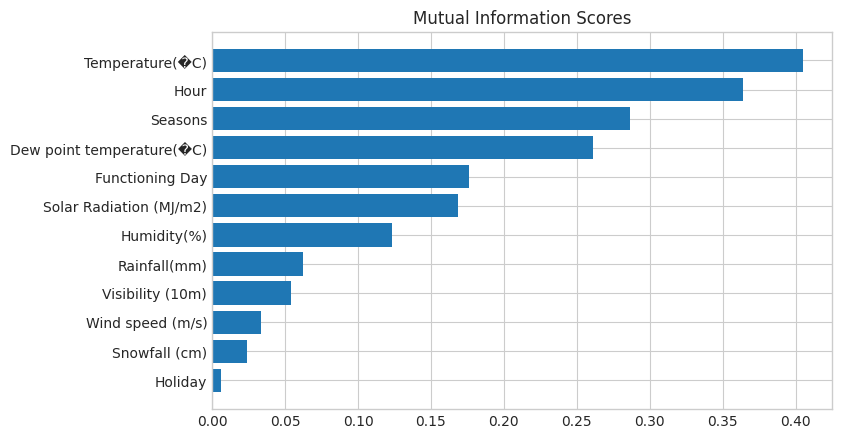

In [21]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## ⚡ Data Preparation

In [22]:
#Reading the file again to provide any mistakes above
raw_file = pd.read_csv("/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv")
file = raw_file.copy()

### ⚡ All functions 

In [23]:
def encodingHoliday(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({'Holiday': 1, 'No Holiday': 0})
    return dataset

def encodingFunctioningDay(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({'Yes': 1, 'No': 0})
    return dataset

def encodingSeasons(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4})
    return dataset

def encoding_label_day_night(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({'Day': 1, 'Night': 0})
    return dataset

def encodingTempLevels(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({'02_Medium_Temp': 0, '01_Low_Temp': 1, '03_High_Temp': 2})
    return dataset

def encodingWindSpeedLevels(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({'02_Medium_Speed': 0, '01_Low_Speed': 1, '03_High_Speed': 2})
    return dataset

def encodingWeekDay(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({'Sunday': 6, 'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5})
    return dataset

def encoding_rush_hours(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({0 : 2, 1: 2, 2: 1, 3: 1, 4: 0, 5: 0,\
                                                       6: 1, 7: 3, 8: 5, 9: 3, 10: 2, 11: 3,\
                                                       12: 4, 13: 4, 14: 4, 15: 4, 16: 5, 17: 6,\
                                                       18: 7, 19: 6, 20:6, 21: 6, 22: 5, 23:3})
    return dataset

def encoding_Peak_hours(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({4 : 0 , 5 : 1 , 3 : 2 , 6 : 3 , 2 : 4 , 1 : 5 , 10 : 6 , 0 : 7 , 11 : 8 , 7 : 9 , 9 : 10 , 23 : 11 , 12 : 12 , 13 : 13 , 14 : 14 , 15 : 15 , 22 : 16 , 16 : 17 , 8 : 18 , 21 : 19 , 20 : 20 , 17 : 21 , 19 : 22 , 18 : 23 })
    return dataset

def normalize_column(file,column):
    return MinMaxScaler().fit_transform(np.array(file[column]).reshape(-1,1))

def removeOutliers(df,outliersColomns):
    z_scores = stats. zscore(df[outliersColomns]) 
    abs_z_scores = np. abs(z_scores)
    filtered_entries = (abs_z_scores < 3). all(axis=1)
    new_df = df[filtered_entries]
    return new_df

def removeDuplicate(df_):
    return (df_.drop_duplicates( keep = False, inplace = True))
     
def oneHotEncoding(df):
    return pd.get_dummies(df, drop_first=True)

def meanEncodingFeature(df_source , df_target , feature_name, label_):
    Mean_encoded_subject = df_source.groupby([feature_name])[label_].mean().to_dict()
    df_target[feature_name] = df_target[feature_name].map(Mean_encoded_subject)
    return df_target

def getMeanEncodingDict( df_source , feature_name, label_):
    return (df_source.groupby([feature_name])[label_].mean().to_dict())

def encodingFeatureWithDict(df_target , feature_name, map_dict):
    #data[num] if num in data else data[min(data.keys(), key=lambda k: abs(k-num))]
    #print('Keys are ',map_dict.keys())
    #df_array= df_target[feature_name].as
    for i in range(len(df_target[feature_name])):
        #print('encoding ',feature_name,' at i=',i,' with value ',df_target[feature_name].array[i])
        if df_target[feature_name].array[i] not in map_dict.keys():
            df_target[feature_name].array[i] = min(map_dict.keys(), key=lambda k: abs(k-df_target[feature_name].array[i]))
    df_target[feature_name] = df_target[feature_name].map(map_dict)
    return df_target

def sortDF(df_,col_name):
    df_= df_.sort_values(by=col_name,ascending=True)
    return df_

def swapDFRows(df_,row_index_1,row_index_2):
    temp = df_.iloc[row_index_1].copy()
    df_.iloc[row_index_1] = df_.iloc[row_index_2]
    df_.iloc[row_index_2] = temp
    return df_

def sortPredictionsAsNormalDistribution(df_source,col_name):
    sortedPredictions = sortDF(df_source,col_name)
    left_ = 0
    right_ = sortedPredictions.y.count()-1
    middle_ = int(sortedPredictions.y.count()/2)
    if (right_%2==0):
        right_=right_-1
    df_left = pd.DataFrame(columns = sortedPredictions.columns)
    df_right = pd.DataFrame(columns = sortedPredictions.columns)
    for i in range(middle_+2):
        #print('i= ',i,' ,left = ',left_,' ,right = ',right_)
        if left_ < (sortedPredictions.y.count()-1) :
            #print(df_left)
            df_left = df_left.append(sortedPredictions.iloc[left_])
        if right_ > 0:
            df_right = df_right.append(sortedPredictions.iloc[right_])
        left_ = left_ + 2
        right_ = right_ - 2
    #print(df_left)
    sortedPredictions = df_left.append(df_right)
    return sortedPredictions

In [24]:
# Transform data
def transformation(df,columns,func):
    for col in columns:
        df[col]=func(df[col])
    return df

#Demo of function params
#transformation(test_df,['Temperature(�C)','Hour'],np.log1p)

# Adding Day Month Year to data frame
def add_day_month_year(df):
    df['Year'] =  pd.DatetimeIndex(df['Date']).year
    df['Month'] =  pd.DatetimeIndex(df['Date']).month
    df['day'] =  pd.DatetimeIndex(df['Date']).day
    df['weekday'] =  pd.DatetimeIndex(df['Date']).dayofweek
    df['weekofyear']= pd.DatetimeIndex(df['Date']).weekofyear
    df['dayofyear']= pd.DatetimeIndex(df['Date']).dayofyear
    #df['Hour']= pd.DatetimeIndex(df['datetime']).hour
    return df

#Dropping Outliers beyond 99 Percentile
def dropOutliersBeyond99(df):
    cnt=df['y'].values
    q99=np.percentile(cnt,[99])
    df=df[df['y']<q99[0]]
    return df

#evaluation matrix
def rmsle(y_pred,y_true):
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)
    log1=np.log(y_pred + 1)
    log2=np.log(y_true + 1)
    se = (log1 - log2) ** 2 
    mse=np.mean(se)
    return np.sqrt(mse)

from sklearn.metrics import make_scorer
myScorer = make_scorer(rmsle, greater_is_better=False)

# PCA
def transform_with_pca(df, columns):
    pca = PCA(n_components=0.9)
    # Find new components
    pca.fit(train_df[colums_for_pca])
    # No. of PCA Components
    # print ('Variance: ', pca.n_components)
    # print ('No. of components to keep: ', pca.n_components_)
    transformed_data = pca.transform(df[columns])
    tcols = []
    for i in range(pca.n_components_):       
        tcols.append('component_' + str(i))
    # print ('components:',tcols)
    df_transformed = pd.DataFrame(transformed_data, columns=tcols)
    for col in df_transformed.columns:
        df[col] = df_transformed[col]
    df=df.drop(columns, axis=1)
    return df


## ⚡ Function of all preparing data

In [25]:
meanEncodersMaps = {}
def PrepareData(rawData,isTest=False):
    test_=rawData.copy()
    
    test_['Day'] = pd.DatetimeIndex(test_['Date']).day
    test_['Month'] = pd.DatetimeIndex(test_['Date']).month
    test_['Year'] = pd.DatetimeIndex(test_['Date']).year
    test_['Date']= pd.to_datetime(test_['Date'],format="%d/%m/%Y")
    
    test_['WeekDay'] = test_["Date"].dt.day_name()

    test_['label_day_night'] = test_['Hour'].apply(lambda x : 'Night' if (x >20 or x<5) else( 'Day'))
    test_['RushHours'] = test_['Hour'].apply(lambda x : 1 if ( (x >=7 and x<=9) or (x >=17 and x<=22)) else( 0))
    test_['Temp_levels'] = test_['Temperature(�C)'].apply(lambda x : '01_Low_Temp' if (x<10) \
                                                        else('02_Medium_Temp' if (x >=10 and x<=35) else( '03_High_Temp')))
    test_['DewLevels']=test_['Dew point temperature(�C)'].apply(lambda x : 4 if (x>=10 and x<=20) else (2 if(x>=-10 and x<0) else (1 if (x<-10) else (3))))
    test_['WindSpeed_levels'] = test_['Wind speed (m/s)'].apply(lambda x : '01_Low_Speed' if (x<4)\
                                                              else('02_Medium_Speed' if (x >=4 and x<=6) else( '03_High_Speed')))
    test_['Rainfall_Levels'] = test_['Rainfall(mm)'].apply(lambda x : 0 if (x>=4) else (0.5 if (x>0 and x<4) else (1)))
    test_['Snowfall_Levels'] = test_['Snowfall (cm)'].apply(lambda x : 0 if (x>0) else (1))
    test_['SnowOrRain'] = test_['Rainfall(mm)']+test_['Snowfall (cm)']
    test_['Is_Winter'] = test_['Seasons'].apply(lambda x : 1 if (x=='Winter') else (0))
    test_['Holiday'] = test_['Holiday'].replace({'Holiday': 1, 'No Holiday': 0})
    test_['RadiationLevels']=test_['Solar Radiation (MJ/m2)'].apply(lambda x : 4 if (x>=0 and x<1.25) else (3 if(x>=1.25 and x<=2) else (1 if (x>2 and x<=2.5) else (2))))
    test_['DaysOFF'] = test_['WeekDay'].apply(lambda x : 1 if ((x == 'Saturday') or (x == 'Sunday')) else(0))
    holiay_features = ["Holiday", "DaysOFF"]
    test_["AllHolidays"] = test_[holiay_features].sum(axis=1)
    test_['AllHolidays'] = test_['AllHolidays'].replace({2: 1})
    test_['VisibilityLevels']=test_['Visibility (10m)'].apply(lambda x : 4 if (x>=1000 and x<1500) else (3 if(x>=1500) else (2 if (x>=500 and x<1000) else (1))))
    test_['HumidityLevels']=test_['Humidity(%)'].apply(lambda x : 3 if (x>=40 and x<=60) else (2 if(x>=20 and x<40) else (2 if (x>60 and x<=80) else (1))))
    test_['InverseVisibility'] = test_['Visibility (10m)'].apply(lambda x : 1/x if(x!=0) else(1))
    test_['BinarySolar'] = test_['Solar Radiation (MJ/m2)'].apply(lambda x : 0 if(x==0) else(1))
    test_['Rainfall(mm)_'] = test_['Rainfall(mm)'].apply(lambda x : math.ceil(x) if (x<35) else (35))
    test_['Snowfall (cm)_'] = test_['Snowfall (cm)'].apply(lambda x : math.ceil(x) if (x<6) else (6))
    
    test_ = test_.drop(columns = ['Date','DaysOFF',])

    test_ = encodingFunctioningDay(test_, ['Functioning Day'])
    test_ = encodingWeekDay(test_, ['WeekDay'])
#     test_ = encodingHoliday(test_, ['Holiday'])
    test_ = encodingTempLevels(test_, ['Temp_levels']) 
    test_ = encodingWindSpeedLevels(test_, ['WindSpeed_levels'])
    test_ = encodingSeasons(test_, ['Seasons']) 
    test_ = encoding_label_day_night(test_, ['label_day_night']) 
        
    global meanEncodersMaps
    MeanEncodedColomns = [ 'Day','Wind speed (m/s)','RushHours',]
    outliersColomns = ['y','Solar Radiation (MJ/m2)',]
    if isTest == False:
        test_ = removeOutliers(test_,outliersColomns)
        test_ = test_[test_['Functioning Day']>0]
        test_['log_y'] = test_['y'].apply(lambda x : np.log(x+1))
        test_['10x_y'] = test_['y'].apply(lambda x : int(x/10))
        for col_name in test_.columns:
            if col_name in MeanEncodedColomns:
                meanEncodersMaps[col_name]= getMeanEncodingDict(test_ , col_name, 'y')

    for col_name in test_.columns:
        if col_name in MeanEncodedColomns:
            test_ = encodingFeatureWithDict(test_ , col_name, meanEncodersMaps[col_name])
            
    ScaledFeatures=[]
    for col_name in test_.columns:
        if col_name in ScaledFeatures:
            test_[col_name]=scale_column(test_,col_name)
    categorical_colomns= ['Hour', 'Seasons','Day', 'Month', 'label_day_night',
       'RushHours', 'Temp_levels', 'DewLevels', 'WindSpeed_levels',
       'Rainfall_Levels', 'Snowfall_Levels', 'Is_Winter',
       'RadiationLevels', 'AllHolidays', 'VisibilityLevels']
#Can't be used with XGBoost       
    # for col_ in categorical_colomns:
    #   test_[col_] = test_[col_].astype('category')
    return test_
  
file = PrepareData(raw_file)

file.sample(1)

,ID,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),...,RadiationLevels,AllHolidays,VisibilityLevels,HumidityLevels,InverseVisibility,BinarySolar,Rainfall(mm)_,Snowfall (cm)_,log_y,10x_y
168,168,233,0,-3.5,49,842.564815,1893,-12.6,0.0,0.0,...,4,0,3,3,0.000528,0,0,0,5.455321,23


In [26]:
print(file.shape)
print(file.columns)

(5423, 37)
Index(['ID', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Day', 'Month', 'Year', 'WeekDay',
       'label_day_night', 'RushHours', 'Temp_levels', 'DewLevels',
       'WindSpeed_levels', 'Rainfall_Levels', 'Snowfall_Levels', 'SnowOrRain',
       'Is_Winter', 'RadiationLevels', 'AllHolidays', 'VisibilityLevels',
       'HumidityLevels', 'InverseVisibility', 'BinarySolar', 'Rainfall(mm)_',
       'Snowfall (cm)_', 'log_y', '10x_y'],
      dtype='object')


In [27]:
# Selecting specific columns for model:

# Uninformative colomns but have reduced the error : Visibility (10m)', 'VisibilityLevels', 'Wind speed (m/s)','Solar Radiation (MJ/m2)'

used_colomns = ['AllHolidays', 'Dew point temperature(�C)', 'Hour', 'Humidity(%)', 'HumidityLevels', 'Month'
                , 'Rainfall(mm)', 'Rainfall_Levels', 'RushHours', 'Seasons', 'Snowfall (cm)_', 'Solar Radiation (MJ/m2)'
                , 'Temperature(�C)', 'Visibility (10m)', 'VisibilityLevels', 'Wind speed (m/s)', 'Year', 'label_day_night']

In [30]:
def ModelPredictionsPostProcessing(predictions_t,train_x,Param = [890, 1000, 200, 1000]):
  #This function do preprossing on the model predictions to decrease the errors of the model
    predictions_ = predictions_t.copy()
    for i in range(len(predictions_)):
      # Remove Negative Values and Set prediction to 0 if not a Functioning Day
        predictions_[i] = max(0,predictions_[i]) * train_x['Functioning Day'].array[i]
        if (train_x['Snowfall_Levels'].array[i] == 0) :
          #if there is Snowfall limit predictions to max expected according to data analysis
          predictions_[i] = min(Param[0],predictions_[i])
        if  (train_x['Rainfall_Levels'].array[i] == 0):
          #if there is High Rainfall limit predictions to max expected according to data analysis
          predictions_[i] = min(Param[1],predictions_[i])
        if  (train_x['Rainfall_Levels'].array[i] == 0.5):
          #if there is Medium Rainfall limit predictions to max expected according to data analysis
          predictions_[i] = min(Param[2],predictions_[i])
        if  (train_x['Is_Winter'].array[i] == 1):
          #In Winter Season limit predictions to max expected according to data analysis
          predictions_[i] = min(Param[3],predictions_[i])
    return predictions_

In [31]:
# PCA

# file_pca = file.copy()
# features = file_pca.columns[2:96] #grab all numeric columns of interest
# z = StandardScaler()
# file_pca[features] = z.fit_transform(file_pca[features])

# pca = PCA(random_state=100)
# pca.fit(file_pca[features])
# pca.explained_variance_ratio_ #tune pca

# data = pca.transform(file_pca[features])
# df1 = pd.DataFrame(data[:,0:50])
# df2 = pd.DataFrame(data[:, 0:30])

# #modeMod1
# lr1 = CatBoostRegressor(random_seed=100,  verbose=False)
# lr1.fit(file_pca[features], file_pca["y"])
# print("all data: ", lr1.score(file_pca[features], file_pca["y"]))

# #modeMod1
# lr2 = CatBoostRegressor(random_seed=100,  verbose=False)
# lr2.fit(df1, file_pca["y"])
# print("50 PCs:   ", lr2.score(df1, file_pca["y"]))

# #modeMod1
# lr3 = CatBoostRegressor(random_seed=100,   verbose=False)
# lr3.fit(df2, file_pca["y"])
# print("30 PCs:    ", lr3.score(df2, file_pca["y"]))

## ⚡  Model Training

In [32]:
#  Lazy Predicror for best model:

# from lazypredict.Supervised import LazyRegressor
# from sklearn.utils import shuffle
# # from sklearn import datasets

# data = file.drop(columns=['ID','y'])
# target = file['y']

# # boston = datasets.load_boston() #boston.data, boston.target
# X, y = shuffle(data, target, random_state=13)
# X = X.astype(np.float32)

# offset = int(X.shape[0] * 0.9)

# X_train, y_train = X[:offset], y[:offset]
# X_test, y_test = X[offset:], y[offset:]

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

## ⚡ Splitting data into training and validation sets

In [33]:
train_df, val_df = train_test_split(file, test_size=0.20, random_state=3) 

x_train = train_df.drop(columns=['ID','y'])
y_train = train_df['y']

x_val = val_df.drop(columns=['ID','y'])
y_val = val_df['y']

x_train_ = x_train.drop(columns=['Functioning Day'])
x_val_ = x_val.drop(columns=['Functioning Day'])

# ⚡ ML Regressor Models:

## 1- Random Forest Regressor

In [34]:
# randomForestAlgo = RandomForestRegressor(n_estimators = 100, 
#          max_depth = 12,
#          min_samples_split=2,
#          min_samples_leaf=2,
#          bootstrap = True,
#          random_state=5,
#          verbose=0,)
# randomForestAlgo.fit(x_train,y_train)
# predictionsRFR = randomForestAlgo.predict(x_val)
# predictionsRFR_T = randomForestAlgo.predict(x_train)

# #remove negative values from target
# Limit_Predictions(predictionsRFR,x_val)
# Limit_Predictions(predictionsRFR_T,x_train)
   
# print("RMSLE for Validate= ", np.sqrt(mean_squared_log_error( y_val, predictionsRFR )))
# print("RMSLE for train= ", np.sqrt(mean_squared_log_error( y_train, predictionsRFR_T )))
# # get importance
# importance = randomForestAlgo.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature ',i,': %s, Score: %.5f' % (x_train.columns[i],v))
# # plot feature importance
# #plt.bar(x_train_.columns.values, importance,width=0.8,)
# plt.bar([x for x in range(len(importance))], importance,width=0.8)
# plt.show()

## 2- CatBoost Regressor

In [35]:
# CatBoost Regressor:

#  Identify columns with categorical features
# categorical_features_indices = np.where(x_train_.dtypes != np.float)[0]  

# #  Pooling data
# #train_data = Pool(x_train, y_train, categorical_features_indices)

# # specify the training parameters ,depth=15,n_estimators=80,l2_leaf_reg=0.01 ,eval_metric=LoglossMetric(), loss_function='Logloss',reg_lambda=6
# #loss_function : string, [default='RMSE']'RMSE','MAE','Quantile:alpha=value','LogLinQuantile:alpha=value','Poisson','MAPE','Lq:q=value','SurvivalAft:dist=value;scale=value
# #(random_seed = i+200, gradient_iterations = i+1 ,leaf_estimation_method ='Newton', learning_rate=0.057, l2_leaf_reg = 23, depth=6, od_pval=0.0000001, iterations = 877, loss_function='Logloss')
# CBR_Model = CatBoostRegressor(learning_rate=0.001,depth=15,l2_leaf_reg=0.001,random_seed=100, iterations=6000, loss_function='Lq:q=2')#, eval_metric = 'RMSE'

# # train the model
# CBR_Model.fit(    
# #    train_data,  #   Tried this with pooled data defined above
#      x_train_,
#      y_train,
#      cat_features=categorical_features_indices,
#      eval_set=[(x_train_, y_train), (x_val_, y_val)],
#      early_stopping_rounds=100,
#      verbose=False)

# predictionsCB = CBR_Model.predict(x_val_)
# predictionsCB_T = CBR_Model.predict(x_train_)

# # remove negative values from target
# predictionsCB=Limit_Predictions(predictionsCB,x_val)
# predictionsCB_T=Limit_Predictions(predictionsCB_T,x_train)
# print("RMSLE for Validate= ", np.sqrt(mean_squared_log_error( y_val, predictionsCB )))
# print("RMSLE for train= ", np.sqrt(mean_squared_log_error( y_train, predictionsCB_T )))

#plot train and validation losses
# results = CBR_Model.evals_result_
# plt.plot(range(len(results['validation_0']['RMSE'])), results['validation_0']['RMSE'])
# plt.plot(range(len(results['validation_1']['RMSE'])), results['validation_1']['RMSE'])
# plt.legend(['Train Error', 'Val Error'])
# plt.show()


## 3- k-fold and XGBoost Regressor

In [36]:
# k-fold and XGBoost Regressor: "Should use GPU Accelerator" with 'tree_method': "gpu_hist" option

def kfold_xgb(train, x_test, target, seed=2020):
    kf = KFold(n_splits=3, shuffle=True, random_state=seed)
    paras = {
        'objective': 'count:poisson',
        'learning_rate': 0.008,
        'lambda': 0.003261847937677995,
        'alpha': 0.041719982269195065, 
        'colsample_bytree': 0.5, 
        'subsample': 1.0,
        'max_depth': 6,
        'min_child_weight': 97,
        'random_state': 24,
        'eval_metric': 'rmse',
        # 'tree_method': "gpu_hist",
    }
    
    y_sub = 0  
    feature_importance_df = pd.DataFrame()  
    
    for fold, (train_index, val_index) in tqdm(enumerate(kf.split(train, target))):
        X_train, X_val = train.iloc[train_index], train.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        data_train = xgb.DMatrix(X_train, y_train)
        data_val = xgb.DMatrix(X_val, y_val)
        watchlist = [(data_train,'train'),(data_val,'val')]
        evals_result={}
        model = xgb.train(dict(paras),data_train, evals = watchlist, num_boost_round=60000, evals_result=evals_result , early_stopping_rounds=100, verbose_eval=False)
        
        
       # test---output
        data_test = xgb.DMatrix(x_test)  
        y_sub = model.predict(data_test)
        

        # features importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = model.get_score().keys()
        fold_importance_df["importance"] = model.get_score().values()  # weight
        # fold_importance_df["importance"] = model.feature_importance(importance_type = 'gain')  # gain

        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
                            
    return y_sub, feature_importance_df, model, evals_result

3it [00:49, 16.48s/it]

RMSLE for Validate =  0.3382917476659172


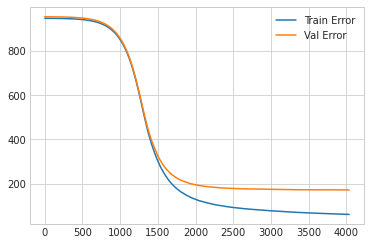

In [37]:
#XGBoost implementation
predictionsXGB, feature_importance, XGB_Model ,evals_result = kfold_xgb(x_train[used_colomns], x_val[used_colomns], y_train)
predictionsXGB = ModelPredictionsPostProcessing(predictionsXGB,x_val)

print("RMSLE for Validate = ", np.sqrt(mean_squared_log_error( y_val, predictionsXGB )))

results = evals_result
plt.plot(range(len(results['train']['rmse'])), results['train']['rmse'])
plt.plot(range(len(results['val']['rmse'])), results['val']['rmse'])
plt.legend(['Train Error', 'Val Error'])
plt.show()

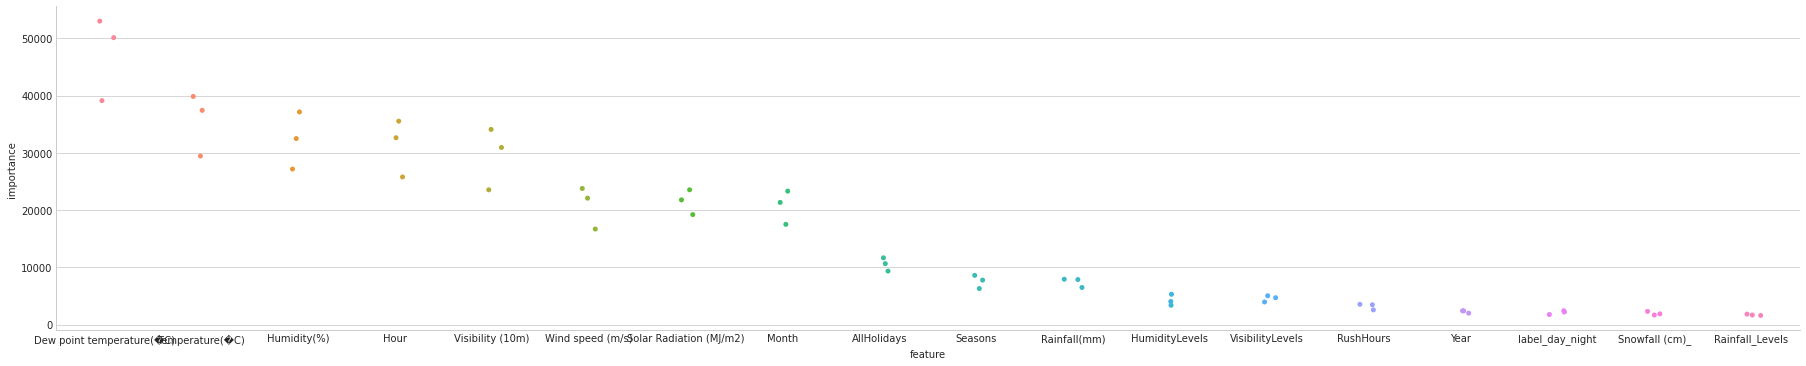

In [62]:
feature_importance=feature_importance.sort_values(by='importance',ascending=False)
sns.catplot('feature', 'importance', data=feature_importance, height=5,aspect=5) 

## 4- Extra Trees Regressor

In [39]:
# Extra Trees Regressor

# extraTreesAlgo = ExtraTreesRegressor(n_estimators = 80, 
#          max_depth = 15,
#          random_state=3,
#          min_samples_split=2,
#          min_samples_leaf=2,
#          bootstrap = True)

# extraTreesAlgo.fit(x_train_,y_train)

# predictionsET = extraTreesAlgo.predict(x_val_)
# predictionsET_T = extraTreesAlgo.predict(x_train_)

# #remove negative values from target
# Limit_Predictions(predictionsET,x_val)
# Limit_Predictions(predictionsET_T,x_train)  
    
# print("RMSLE for Validate= ", np.sqrt(mean_squared_log_error( y_val, predictionsET )))
# print("RMSLE for train= ", np.sqrt(mean_squared_log_error( y_train, predictionsET_T )))

# # summarize feature importance
# importance = extraTreesAlgo.feature_importances_
# for i,v in enumerate(importance):
#     print('Feature: %s, Score: %.5f' % (x_train_.columns[i],v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

## 5- Hist Grad Boost Regressor:

In [40]:
# Hist Grad Boost Regressor:
# from sklearn.experimental    import enable_hist_gradient_boosting
# from sklearn.ensemble        import HistGradientBoostingRegressor
# %%time

# kf = KFold(n_splits=10, random_state=42, shuffle=True)

# predictions_array = []
# CV_score_array    = []

# for train_index, test_index in kf.split(X):
    
#     X_train, X_valid = X[train_index], X[test_index]
#     y_train, y_valid = y[train_index], y[test_index]
    
#     regressor =  HistGradientBoostingRegressor()
#     regressor.fit(X_train, y_train)
    
#     predictions_array.append(regressor.predict(X_test))
#     CV_score_array.append(mean_absolute_error(y_valid,regressor.predict(X_valid)))    

# predictions = np.mean(predictions_array,axis=0)

In [41]:
# histogram-based gradient boosting for regression in scikit-learn
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_regression
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# from matplotlib import pyplot
# # define dataset
# X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# # evaluate the model
# model = HistGradientBoostingRegressor()
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# # fit the model on the whole dataset
# model = HistGradientBoostingRegressor()
# model.fit(X, y)
# # make a single prediction
# row = [[2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
# yhat = model.predict(row)
# print('Prediction: %.3f' % yhat[0])

### Grid Search:

In [42]:

# RMSE_RF =[]
# for randomx in range(2,20):
#     train_df, val_df = train_test_split(file, test_size=0.20, random_state=randomx) 
#     x_train = train_df.drop(columns=['ID','y'])
#     y_train = train_df['y']

#     x_val = val_df.drop(columns=['ID','y'])
#     y_val = val_df['y']
#     randomForestAlgo = RandomForestRegressor()
#     param = {'n_estimators' : [80], 
#              'max_depth' : [12],
#              'min_samples_split':[2],
#              'min_samples_leaf':[2],
#              'bootstrap' : [True]
#             }
#     gridSearch_RandomForest=GridSearchCV(randomForestAlgo,param,scoring='r2',cv=5)
#     gridSearch_RandomForest.fit(x_train,y_train)
#     predictionsRFR = gridSearch_RandomForest.predict(x_val)

#     #remove negative values from target
#     for i in range(len(predictionsRFR)):
#         predictionsRFR[i] = max(0,predictionsRFR[i]) * x_val['Functioning Day'].array[i]
#     RMSE_RF.append(np.sqrt(mean_squared_log_error( y_val, predictionsRFR )))

# df = pd.DataFrame()
# df['RMSE_RF_df'] = RMSE_RF
# print("RMSLE max = ",df['RMSE_RF_df'].max()*100,'%'  )
# print("RMSLE min = ",df['RMSE_RF_df'].min()*100,'%'  )
# print("RMSLE diff= ",(df['RMSE_RF_df'].max()-df['RMSE_RF_df'].min())*100,'%' )
# print("RMSLE mean = ",df['RMSE_RF_df'].mean()*100,'%'  )
# df

In [43]:
# gridSearch_RandomForest.get_params(all)

In [44]:
# test for RandomForestRegressor best parametes

# for depth in range(2,100):
#         param = {'n_estimators' : [depth], 
#          'max_depth' : [12],
#          'min_samples_split':[5],
#          'min_samples_leaf':[2],
#          'bootstrap' : [True]
#         }
#         gridSearch_RandomForest=GridSearchCV(randomForestAlgo,param,scoring='r2',cv=5)
#         gridSearch_RandomForest.fit(x_train,y_train)
#         predictionsRFR = gridSearch_RandomForest.predict(x_val)
#         for i in range(len(predictionsRFR)):
#             predictionsRFR[i] = max(0,predictionsRFR[i]) * x_val['Functioning Day'].array[i]
#         print("max_depth= ",depth," RMSLE= ", np.sqrt(mean_squared_log_error( y_val, predictionsRFR )))
        

In [45]:
# remove test file from working directory
#os.remove('./test.csv')

## 6- Linear Regressor:

In [46]:
# #LinearReggression Model:

# # Using polynomial LinearRegression on the dataset
# reg = LinearRegression().fit(x_train, y_train)
# predictionsLiR = reg.predict(x_val)

# #remove negative values from target
# for i in range(len(predictionsLiR)):
#     predictionsLiR[i] = max(0,predictionsLiR[i])
    
# #RMSLE
# print("RMSLE= ", np.sqrt(mean_squared_log_error( y_val, predictionsLiR )))
# # get importance
# importance = reg.coef_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %s, Score: %.5f' % (x_train.columns[i],v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

## 7- SVR reggressor:

In [47]:
# test for SVR best parametes

# for depth in [7000]:
#         param = {'C' : [depth]}
#         gridSearchSVR=GridSearchCV(svr_Model, param, scoring='r2', cv=5)
#         gridSearchSVR.fit(x_train, y_train)
#         predictionsSVR = gridSearchSVR.predict(x_val)
#         for i in range(len(predictionsSVR)):
#             predictionsSVR[i] = max(0,predictionsSVR[i])
#         print("max_depth= ",depth,"RMSLE= ", np.sqrt(mean_squared_log_error( y_val, predictionsSVR )))


In [48]:
# # SVR regression model:

# svr_Model=SVR(kernel='rbf',C= 7000)
# #'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
# svr_Model.fit(x_train, y_train)

# predictionsSVR = svr_Model.predict(x_val)
# predictionsSVR_T = svr_Model.predict(x_train)

# #remove negative values from target
# for i in range(len(predictionsSVR)):
#     predictionsSVR[i] = max(0,predictionsSVR[i]) * x_val['Functioning Day'].array[i]
# for i in range(len(predictionsSVR_T)):
#     predictionsSVR_T[i] = max(0,predictionsSVR_T[i]) * x_train['Functioning Day'].array[i]    
    
# print("RMSLE for Validate= ", np.sqrt(mean_squared_log_error( y_val, predictionsSVR )))
# print("RMSLE for train= ", np.sqrt(mean_squared_log_error( y_train, predictionsSVR_T )))


## 8- XGboost without kfold:

In [49]:
# # xgboost for feature importance on a regression problem
# from xgboost import XGBRegressor
# # define the model
# XGB_model = XGBRegressor()
# # fit the model
# XGB_model.fit(x_train, y_train)

# predictionsXGB = XGB_model.predict(x_val)
# predictionsXGB_T = XGB_model.predict(x_train)

# #remove negative values from target
# for i in range(len(predictionsXGB)):
#     predictionsXGB[i] = max(0,predictionsXGB[i]) * x_val['Functioning Day'].array[i]
# for i in range(len(predictionsXGB_T)):
#     predictionsXGB_T[i] = max(0,predictionsXGB_T[i]) * x_train['Functioning Day'].array[i]    
    
# print("RMSLE for Validate= ", np.sqrt(mean_squared_log_error( y_val, predictionsXGB )))
# print("RMSLE for train= ", np.sqrt(mean_squared_log_error( y_train, predictionsXGB_T )))

# # get importance
# importance = XGB_model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %s, Score: %.5f' % (x_train.columns[i],v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

## 9- Ridge Regressor:

In [50]:
# test for Ridge best parametes

# for depth in range(50,150,1):
#         ridge=Ridge()
#         parameters={'alpha':[depth]}
#         gridSearchRidge=GridSearchCV(ridge, parameters, scoring='r2', cv=3)
#         gridSearchRidge.fit(x_train,y_train)
#         predictionsRg = gridSearchRidge.predict(x_val)
#         #remove negative values from target
#         for i in range(len(predictionsRg)):
#             predictionsRg[i] = max(0,predictionsRg[i])
#         print("max_depth= ",depth,"RMSLE= ", np.sqrt(mean_squared_log_error( y_val, predictionsRg )))
        

In [51]:
# Ridge regression model:

# ridge=Ridge()
# parameters={'alpha':[100]}
# gridSearchRidge=GridSearchCV(ridge, parameters, scoring='r2', cv=3)
# gridSearchRidge.fit(x_train,y_train)

# predictionsRg = gridSearchRidge.predict(x_val)

# #remove negative values from target
# for i in range(len(predictionsRg)):
#     predictionsRg[i] = max(0,predictionsRg[i])
# print("RMSLE= ", np.sqrt(mean_squared_log_error( y_val, predictionsRg )))


## 9- Decission Tree Regressor:

In [52]:
# Decision Tree Regressor

# decisionTree = DecisionTreeRegressor()

# param = {'max_depth' : [10]}

# gridSearch_decisionTree=GridSearchCV(decisionTree,param,scoring='r2',cv=6)
# gridSearch_decisionTree.fit(x_train,y_train)

# predictionsDT = gridSearch_decisionTree.predict(x_val)
# predictionsDT_T = gridSearch_decisionTree.predict(x_train)

# #remove negative values from target
# for i in range(len(predictionsDT)):
#     predictionsDT[i] = max(0,predictionsDT[i]) * x_val['Functioning Day'].array[i]
# for i in range(len(predictionsDT_T)):
#     predictionsDT_T[i] = max(0,predictionsDT_T[i]) * x_train['Functioning Day'].array[i]    
    
# print("RMSLE for Validate= ", np.sqrt(mean_squared_log_error( y_val, predictionsDT )))
# print("RMSLE for train= ", np.sqrt(mean_squared_log_error( y_train, predictionsDT_T )))


In [53]:
# # decision tree for feature importance on a regression problem
# from sklearn.tree import DecisionTreeRegressor

# # define the model
# model = DecisionTreeRegressor()
# # fit the model
# model.fit(x_train,y_train)
# # get importance
# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %s, Score: %.5f' % (x_train.columns[i],v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

### Comparing models predictions:

In [54]:
# Comparing Model's RMSLE Scores:

# df = pd.DataFrame()
# df['Y'] = y_val
# df['RFC'] = predictionsRFC
# df['LiR'] = predictionsLiR
# #df['LoR'] = predictionsLoR
# df['RFR'] = predictionsRFR
# #df['SVR'] = predictionsSVR
# # Ensemble methods: regression
# df['Merged'] = (predictionsRFR + predictionsSVR)/2
# df
#print("RMSLE= ", np.sqrt(mean_squared_log_error( y_val, ((predictionsRFR + predictionsET )/2) )))

#Since we know that the output is never less than 1 we replace all negative values with 1 before appending in pre to calculate error.
#plt = sns.residplot(x = predictionsRFR, y = y_val, lowess = True,color = 'r')

In [55]:
# Train with ALL DATA to increase accuracy after it has been validated.

# file = sortPredictionsAsNormalDistribution(file,"y")
x_train = file.drop(columns=['ID','y'])
y_train = file['y']

x_train_ = x_train.drop(columns=['Functioning Day'])
x_val_ = x_val.drop(columns=['Functioning Day'])

# ⚡ Reading the test file

In [56]:
raw_test = pd.read_csv('/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv')

In [57]:
test=raw_test
test

,ID,Date,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,5760,21/12/2017,0,-1.3,90,2.0,259,-2.7,0.0,0.0,2.2,Winter,No Holiday,Yes
1,5761,21/12/2017,1,-1.8,90,1.6,263,-3.2,0.0,0.0,2.2,Winter,No Holiday,Yes
2,5762,21/12/2017,2,-2.2,88,1.4,348,-3.9,0.0,0.0,2.2,Winter,No Holiday,Yes
3,5763,21/12/2017,3,-2.9,89,1.3,288,-4.4,0.0,0.0,2.2,Winter,No Holiday,Yes
4,5764,21/12/2017,4,-3.6,91,1.2,241,-4.8,0.0,0.0,2.2,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,8755,30/11/2018,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
2996,8756,30/11/2018,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
2997,8757,30/11/2018,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
2998,8758,30/11/2018,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [58]:
test.describe()

,ID,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,7259.500000,11.500000,13.035300,57.966000,1.727933,1366.005333,4.103667,0.562940,0.174733,0.130300
std,866.169729,6.923341,12.026752,21.330288,1.013826,643.374688,13.170840,0.866555,1.223086,0.592634
min,5760.000000,0.000000,-17.800000,0.000000,0.000000,33.000000,-30.600000,0.000000,0.000000,0.000000
25%,6509.750000,5.750000,3.900000,40.000000,0.900000,779.000000,-3.900000,0.000000,0.000000,0.000000
50%,7259.500000,11.500000,13.950000,58.000000,1.500000,1591.500000,4.900000,0.010000,0.000000,0.000000
75%,8009.250000,17.250000,22.900000,76.000000,2.400000,2000.000000,15.600000,0.910000,0.000000,0.000000
max,8759.000000,23.000000,38.000000,98.000000,6.900000,2000.000000,26.800000,3.520000,29.500000,8.800000


## ⚡ Test set preprocessing:

In [59]:
test = PrepareData(raw_test,True)
test.sample(10)

,ID,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),...,SnowOrRain,Is_Winter,RadiationLevels,AllHolidays,VisibilityLevels,HumidityLevels,InverseVisibility,BinarySolar,Rainfall(mm)_,Snowfall (cm)_
1342,7102,22,18.3,54,852.883838,1394,8.8,0.00,0.0,0.0,...,0.0,0,4,0,4,3,0.000717,0,0,0
1452,7212,12,23.2,64,757.216667,1305,16.0,2.08,0.0,0.0,...,0.0,0,1,0,4,2,0.000766,1,0,0
2234,7994,2,23.4,79,483.475000,1045,19.5,0.00,0.0,0.0,...,0.0,0,4,0,4,2,0.000957,0,0,0
152,5912,8,-10.2,35,805.232044,2000,-22.7,0.00,0.0,0.0,...,0.0,1,4,0,3,2,0.000500,0,0,0
897,6657,9,12.4,66,573.004098,546,6.2,0.91,0.0,0.0,...,0.0,0,4,0,2,2,0.001832,1,0,0
954,6714,18,17.4,57,845.695652,657,8.7,0.52,0.0,0.0,...,0.0,0,4,0,2,3,0.001522,1,0,0
2732,8492,20,7.6,59,653.761538,2000,0.0,0.00,0.0,0.0,...,0.0,0,4,0,3,3,0.000500,0,0,0
521,6281,17,-0.9,34,934.333333,2000,-14.8,0.28,0.0,1.8,...,1.8,1,4,0,3,2,0.000500,1,0,2
1683,7443,3,22.3,96,755.519084,290,21.6,0.00,0.1,0.0,...,0.1,0,4,0,1,1,0.003448,0,1,0
164,5924,20,-5.9,34,625.000000,2000,-19.2,0.00,0.0,0.0,...,0.0,1,4,0,3,2,0.000500,0,0,0


# ⚡ Generating Submission CSV output file:

In [60]:

X_test = test
X_test = X_test.drop(columns=['ID'])
# Train the model with all the data and predict the test file.
y_test_predicted_XGB,feature_importance,XGB_Model ,evals_result = kfold_xgb(x_train[used_colomns], X_test[used_colomns], y_train)

y_test_predicted_XGB = ModelPredictionsPostProcessing(y_test_predicted_XGB, X_test)

test['y'] = y_test_predicted_XGB
test

3it [01:11, 23.83s/it]


,ID,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),...,Is_Winter,RadiationLevels,AllHolidays,VisibilityLevels,HumidityLevels,InverseVisibility,BinarySolar,Rainfall(mm)_,Snowfall (cm)_,y
0,5760,0,-1.3,90,841.229050,259,-2.7,0.0,0.0,2.2,...,1,4,0,1,1,0.003861,0,0,3,110.535271
1,5761,1,-1.8,90,729.149038,263,-3.2,0.0,0.0,2.2,...,1,4,0,1,1,0.003802,0,0,3,99.688690
2,5762,2,-2.2,88,852.154867,348,-3.9,0.0,0.0,2.2,...,1,4,0,1,1,0.002874,0,0,3,68.994148
3,5763,3,-2.9,89,731.767442,288,-4.4,0.0,0.0,2.2,...,1,4,0,1,1,0.003472,0,0,3,44.116936
4,5764,4,-3.6,91,755.519084,241,-4.8,0.0,0.0,2.2,...,1,4,0,1,1,0.004149,0,0,3,32.661343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,8755,19,4.2,34,842.564815,1894,-10.3,0.0,0.0,0.0,...,0,4,0,3,2,0.000528,0,0,0,948.022461
2996,8756,20,3.4,37,835.920290,2000,-9.9,0.0,0.0,0.0,...,0,4,0,3,2,0.000500,0,0,0,843.658386
2997,8757,21,2.6,39,451.625000,1968,-9.9,0.0,0.0,0.0,...,0,4,0,3,2,0.000508,0,0,0,685.902161
2998,8758,22,2.1,41,573.004098,1859,-9.8,0.0,0.0,0.0,...,0,4,0,3,3,0.000538,0,0,0,727.667847


In [61]:
test[['ID', 'y']].to_csv('/kaggle/working/submission.csv', index=False)